# Insider Threat Detection (CERT Dataset)

#### Merge logon.csv + file.csv, train models, save autoencoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
import os

### Load Data 


In [2]:
logon = pd.read_csv("data/logon.csv")
file = pd.read_csv("data/file.csv")

### Preprocess logon

In [4]:
logon['date'] = pd.to_datetime(logon['date'])
logon['hour'] = logon['date'].dt.hour
logon['dayofweek'] = logon['date'].dt.dayofweek

logon_features = logon.groupby(['user', logon['date'].dt.date]).agg(
    logon_count=('pc', 'count'),
    unique_pcs=('pc', 'nunique'),
    failed_logons=('activity', lambda x: (x == 'Logoff').sum())
).reset_index()

### Preprocess file

In [6]:
file_features = file.groupby(['user', file['date'].dt.date]).agg(
    files_accessed=('filename', 'count')
).reset_index()


### Merge

In [7]:
df = pd.merge(logon_features, file_features, on=['user','date'], how='outer').fillna(0)
features = ['logon_count','unique_pcs','failed_logons','files_accessed']  # remove 'total_file_size'


### Feature Scaling

In [9]:
features = ['logon_count','unique_pcs','failed_logons','files_accessed']
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Isolation Forest

In [10]:
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_iso'] = iso.fit_predict(X_scaled)

### Autoencoder

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

input_dim = X_scaled.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

for epoch in range(30):
    output = model(X_tensor)
    loss = criterion(output, X_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")


Epoch 0, Loss 1.0217
Epoch 5, Loss 0.9923
Epoch 10, Loss 0.9618
Epoch 15, Loss 0.9288
Epoch 20, Loss 0.8912
Epoch 25, Loss 0.8474


### Save model

In [12]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/autoencoder.pth")


### Reconstruction error

In [13]:
recon = model(X_tensor).detach().numpy()
mse = np.mean(np.square(X_scaled - recon), axis=1)
threshold = np.percentile(mse, 95)
df['anomaly_auto'] = (mse > threshold).astype(int)

### Visualization

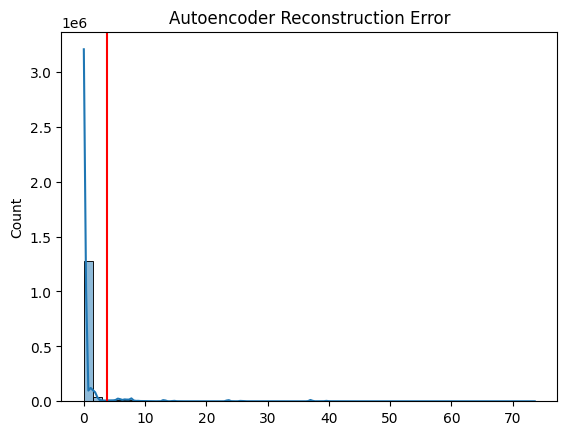

,user,date,logon_count,unique_pcs,failed_logons,files_accessed,anomaly_iso,anomaly_auto
0,AAB0162,2010-01-04,2,1,1,0.0,1,0
1,AAB0162,2010-01-05,2,1,1,0.0,1,0
2,AAB0162,2010-01-06,2,1,1,0.0,1,0
3,AAB0162,2010-01-07,2,1,1,0.0,1,0
4,AAB0162,2010-01-08,2,1,1,0.0,1,0


In [14]:
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='red')
plt.title("Autoencoder Reconstruction Error")
plt.show()

df.head()